In [2]:
%%time
import os
import traceback
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb
import seaborn as sns
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



user='hifld_summer'
pw='hifld_summer'
name='hifld_summer'
host='moria'
port=2023
engine = sqlalchemy.create_engine(
    f'postgresql://{user}:{pw}@{host}:{port}/{name}'
    )

CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time
"MODEL SET-UP"
"Loading in the data from the database"

sql ="""
select * from results.all_features_w_class
"""
df = pd.read_sql_query(sql, con=engine)

CPU times: total: 51.7 s
Wall time: 1min 5s


In [ ]:
df.columns

In [ ]:
%%time
"Dropping unnecessary columns (leaving only features and label) and setting index"

df = df.drop(columns=['geom', 'use_code_std_lps', 'use_code_std_desc_lps', 'parcel_lid', 'build_id', 'prim_occ'])

df.set_index('uuid', inplace=True)

In [ ]:
df.head(2)

In [ ]:
"Undersampling the minority class in order to reduce class imbalance"

df_class_0 = df[df['mh_flag'] == 0]
df_class_1 = df[df['mh_flag'] == 1]
 
# Oversample minority class
df_class_0_undersampled = resample(df_class_0,
                                  replace=True,      
                                  n_samples=len(df_class_1),  
                                  random_state=13)  
 
df_balanced = pd.concat([df_class_1, df_class_0_undersampled])
print('Balanced dataframe:', df_balanced['mh_flag'].value_counts())
print('Imbalanced dataframe:', df['mh_flag'].value_counts())

In [ ]:
%%time
"Seperating dataframe into x (features) and y (label)"

X = df_balanced.drop(columns=['mh_flag'], axis=1)
y = df_balanced['mh_flag']

In [ ]:
%%time
"Checking for class imbalance"

df_balanced.mh_flag.value_counts(normalize=True)

In [10]:
%%time
"Splitting into training and testing datasets"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

CPU times: total: 359 ms
Wall time: 358 ms


In [11]:
%%time
"Standardizing training set and applying the standardization to the training set"

sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

CPU times: total: 141 ms
Wall time: 133 ms


In [12]:
%%time
"Saving the standard scaler"

dump(sc, 'my_standard_scaler.pkl')

CPU times: total: 31.2 ms
Wall time: 6.22 ms


['my_standard_scaler.pkl']

In [13]:
%%time
"Loading the standard scaler back"

same_scaler = load('my_standard_scaler.pkl')

CPU times: total: 0 ns
Wall time: 2.64 ms


In [14]:
%%time
"Applying the standardization to the testing set"


X_test_scaled = same_scaler.transform(X_test)

X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

CPU times: total: 46.9 ms
Wall time: 46.9 ms


In [15]:
"-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------"

'-----CLASSIFICATION MODELS---------------------------------------------------------------------------------------------------------------------------'

In [69]:
%%time
"XGBOOST CLASSIFIER"

base_xg = xgb.XGBClassifier()

CPU times: total: 0 ns
Wall time: 0 ns


In [70]:
param_grid = {'max_depth': [2, 5, 10, 20],
              'max_leaves': [2, 5, 10, 20]}

In [75]:
grid = GridSearchCV(estimator=base_xg, param_grid=param_grid, scoring='f1')

In [76]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'max_leaves': [2, 5, 10, 20]},
             scoring='f1')

In [77]:
print(grid.best_params_)

{'max_depth': 5, 'max_leaves': 20}


In [79]:
%%time
"Fitting random forest"
final_xg = xgb.XGBClassifier(max_depth=5, max_leaves=20)

final_xg.fit(X_train, y_train)

CPU times: total: 9.36 s
Wall time: 1.46 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=20,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [80]:
%%time
"Using the trained random forest to predict on the testing set"

final_xg_predict = final_xg.predict(X_test)

CPU times: total: 484 ms
Wall time: 97.7 ms


In [81]:
%%time
"Checking validity of the random forest's output"

final_xg_predict

CPU times: total: 0 ns
Wall time: 0 ns


array([0, 0, 0, ..., 1, 1, 0])

In [82]:
%%time
"Creating a confusion matrix for the random forest"

xg_cmatrix = confusion_matrix(y_test, final_xg_predict)
print(xg_cmatrix)

[[40316 15135]
 [ 8260 47218]]
CPU times: total: 62.5 ms
Wall time: 49 ms


In [83]:
%%time
"Creating a classification report for the random forest"

print(classification_report(y_test, final_xg_predict))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     55451
           1       0.76      0.85      0.80     55478

    accuracy                           0.79    110929
   macro avg       0.79      0.79      0.79    110929
weighted avg       0.79      0.79      0.79    110929

CPU times: total: 219 ms
Wall time: 211 ms


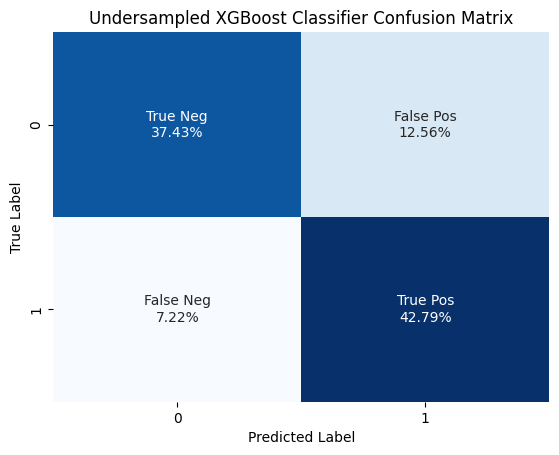

CPU times: total: 109 ms
Wall time: 106 ms


In [29]:
%%time
"Creating a heatmap for the random forest's confusion matrix"

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_percentages = ["{0:.2%}".format(value) for value in
                     xg_cmatrix.flatten()/np.sum(xg_cmatrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(xg_cmatrix, annot=labels, fmt='', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Undersampled XGBoost Classifier Confusion Matrix')

plt.show()

In [61]:
# Using a random sample of the dataframe for better time computation
X_sampled = X_test.sample(1000, random_state=10)

explainer = shap.Explainer(base_xg.predict, X_sampled)
shap_values = explainer(X_sampled)
print("done")

PermutationExplainer explainer: 1001it [02:36,  5.96it/s]                          

done


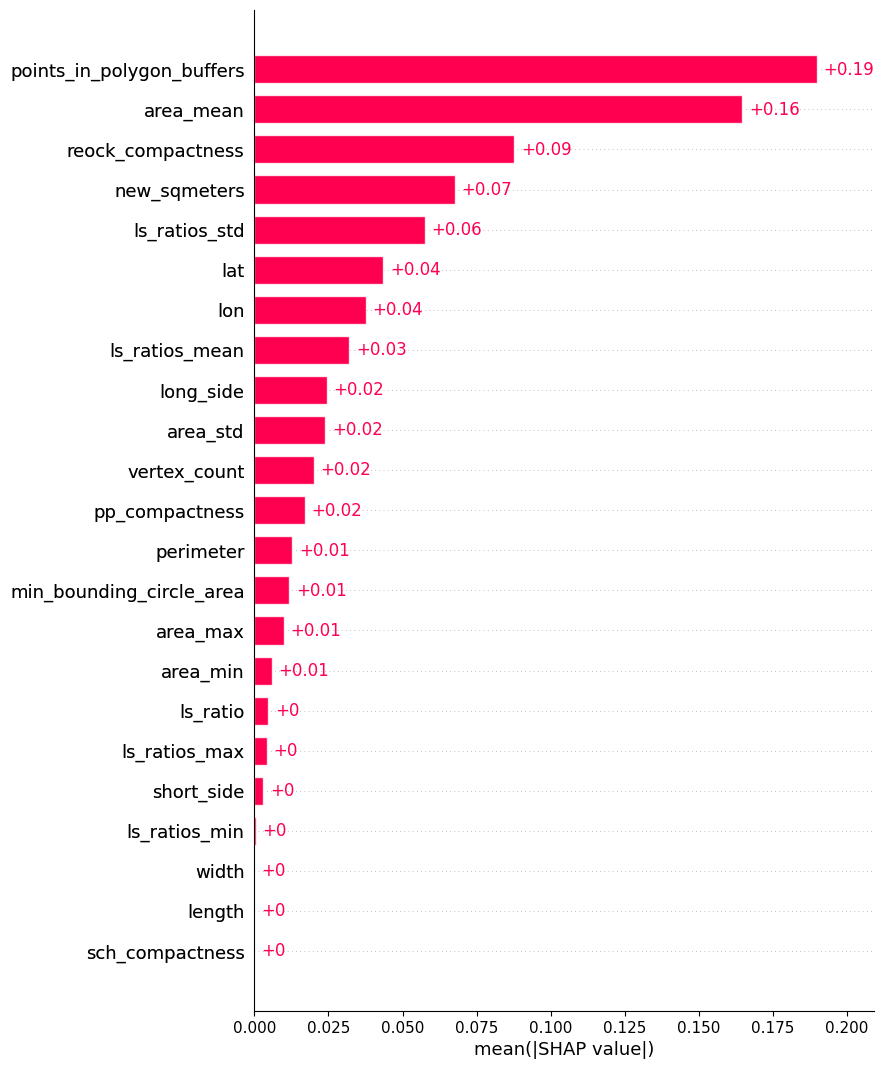

In [66]:
shap.plots.bar(shap_values, max_display=None)


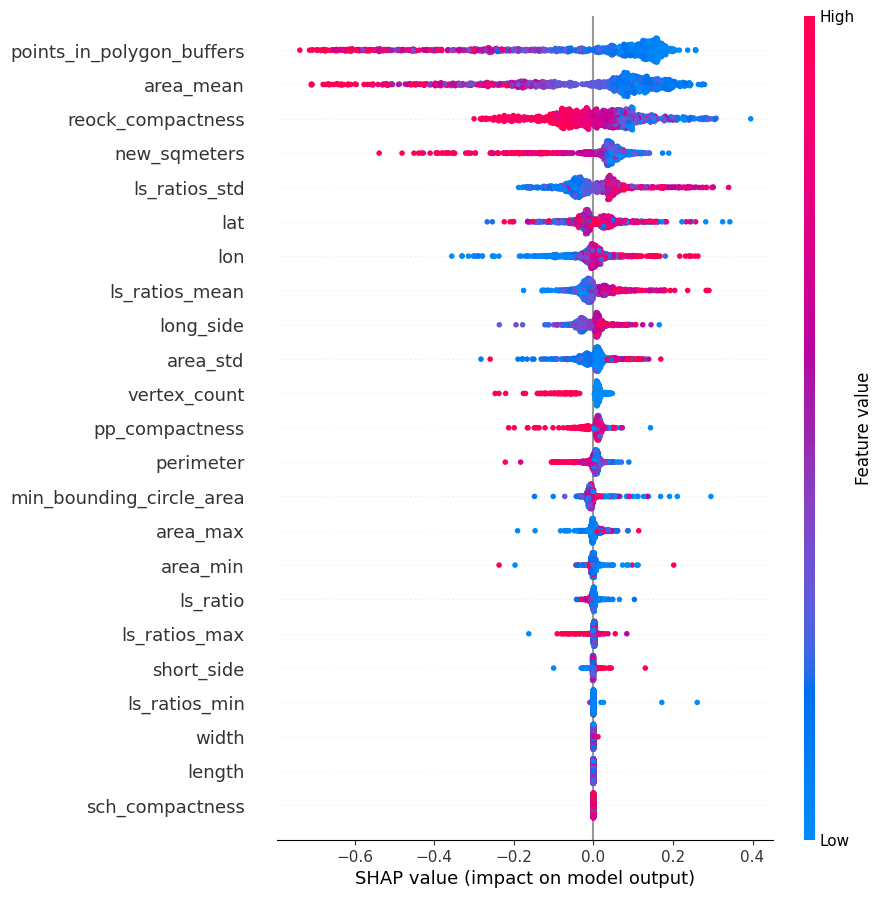

In [67]:
shap.plots.beeswarm(shap_values, max_display = None)